In [1]:
import pathlib
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms as T
from tqdm.notebook import tqdm_notebook
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.get_device_name()

cuda:0


'NVIDIA GeForce GTX 1660 Ti with Max-Q Design'

In [4]:
RESNET_PATH_A = './resnet18_a.pth'
RESNET_PATH_B = './resnet18_b.pth'
RESNET_PATH_C = './resnet18_c.pth'
RESNET_PATH_C_aug = './resnet18_c_augm1.pth'

input_size = 244
batch_size = 32
num_classes = 10
log_dir = pathlib.Path.cwd() / "tensorboard_logs"
writer = SummaryWriter(log_dir)

In [5]:
# from torch.utils.tensorboard import SummaryWriter

# # default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [6]:
transform = T.Compose([
    T.RandomAffine(degrees=(0,15), translate=(0.1, 0.3), scale=(0.75, 1.0)),
    T.RandomAdjustSharpness(sharpness_factor=2),
    T.RandomAutocontrast(),
    T.Resize(input_size),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
test_transform = T.Compose([
#     T.RandomAffine(degrees=(0,15), translate=(0.1, 0.3), scale=(0.75, 1.0)),
#     T.RandomAdjustSharpness(sharpness_factor=2),
#     T.RandomAutocontrast(),
    T.Resize(input_size),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

other_transform = T.Compose([
    T.Resize((input_size, input_size)),
    T.ToTensor(),
    T.Normalize(mean=0., std=1.)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# print('train + val:',trainset)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
# print('train set:',trainset.dataset)
# print('val set:', valset.dataset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
simple_testset = torchvision.datasets.CIFAR10(root='./data', train = False,
                                      download=True, transform=T.Compose([
                                          T.ToTensor(),
                                          T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]))
simple_testloader = torch.utils.data.DataLoader(simple_testset, batch_size=1, shuffle=True)


Files already downloaded and verified


(1, 3, 32, 32)
ship


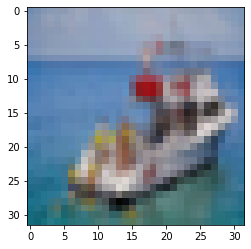

In [57]:
from PIL import Image

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def imshow(img, label):
    img = img / 2 + 0.5     # unnormalize
    # print('1')
    npimg = img.numpy()
    # print('2')
    print(npimg.shape)
    plt.imshow(np.transpose(npimg[0], (1, 2, 0)))
    
    # print('3')
    plt.savefig(classes[label] + '.jpg', bbox_inches = 'tight', pad_inches=0)
#     plt.show()
    
image, label = next(iter(simple_testloader))

imshow(image, label.item())
# imshow(torchvision.utils.make_grid(image))

print(classes[label])

In [58]:
# mask_500 = []
# count_by_class = [0]*10
# for i in range(40000):
#     _, label = trainset.dataset[i]
#     if count_by_class[label] < 500:
#         mask_500.append(i)
#         count_by_class[label] +=1
# print(len(mask_500))
# print(count_by_class)

In [59]:
# tiny_trainset = torch.utils.data.Subset(trainset, mask_500)
# tiny_trainloader = torch.utils.data.DataLoader(tiny_trainset, batch_size=batch_size,
#                                               shuffle=True, num_workers=2)
# print(type(tiny_trainloader.dataset))

In [60]:
# from raw_resnet import resnet18, ResNetBasicCustomBlock

# resnet18_c = resnet18(3, 10,block=ResNetBasicCustomBlock)
resnet18_a = models.resnet18()
resnet18_a = resnet18_a.to(device)
resnet18_a.load_state_dict(torch.load(RESNET_PATH_A))

resnet18_b = models.resnet18()
resnet18_b = resnet18_b.to(device)
#resnet18_b.load_state_dict(torch.load(RESNET_PATH_B))


## For PART 2A

In [61]:
# we will save the conv layer weights in this list

model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []# get all the model children as list
model_children = list(resnet18_a.children())#counter to keep count of the conv layers
counter = 0#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 17
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256

In [62]:
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# def imshow(img):
#     print('start transforming')
#     img = img / 2 + 0.5     # unnormalize
#     # print('1')
#     npimg = img.numpy()
#     # print('2')
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     # print('3')
#     plt.show()
    
# testiter = iter(testloader)

# images, labels = testiter.next()
# image, label = images[2], labels[2]
# imshow(torchvision.utils.make_grid(image))
# images, labels = images.to(device), labels.to(device)

# print(classes[label])

In [63]:
# from PIL import Image

# npimg = np.transpose(image.numpy(), (1,2,0))
# print(npimg.shape)
# pil_img = Image.fromarray(np.int32(npimg))#.astype('unit8'), 'RGB')
# image = other_transform(pil_img) #np.transpose(npimg, (1,2,0)))
# image = image.unsqueeze(0)
# image = image.to(device)

(237, 235)
Image shape before: torch.Size([3, 244, 244])
Image shape after: torch.Size([1, 3, 244, 244])
17


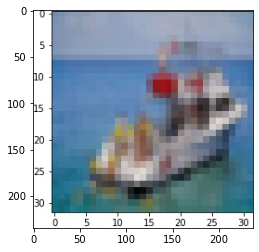

In [67]:
from PIL import Image

image = Image.open(str('ship.jpg'))
plt.imshow(image)
print(image.size)
image= other_transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))#print feature_maps
# for feature_map in outputs:
#     print(feature_map.shape)
    
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
# for fm in processed:
#     print(fm.shape)

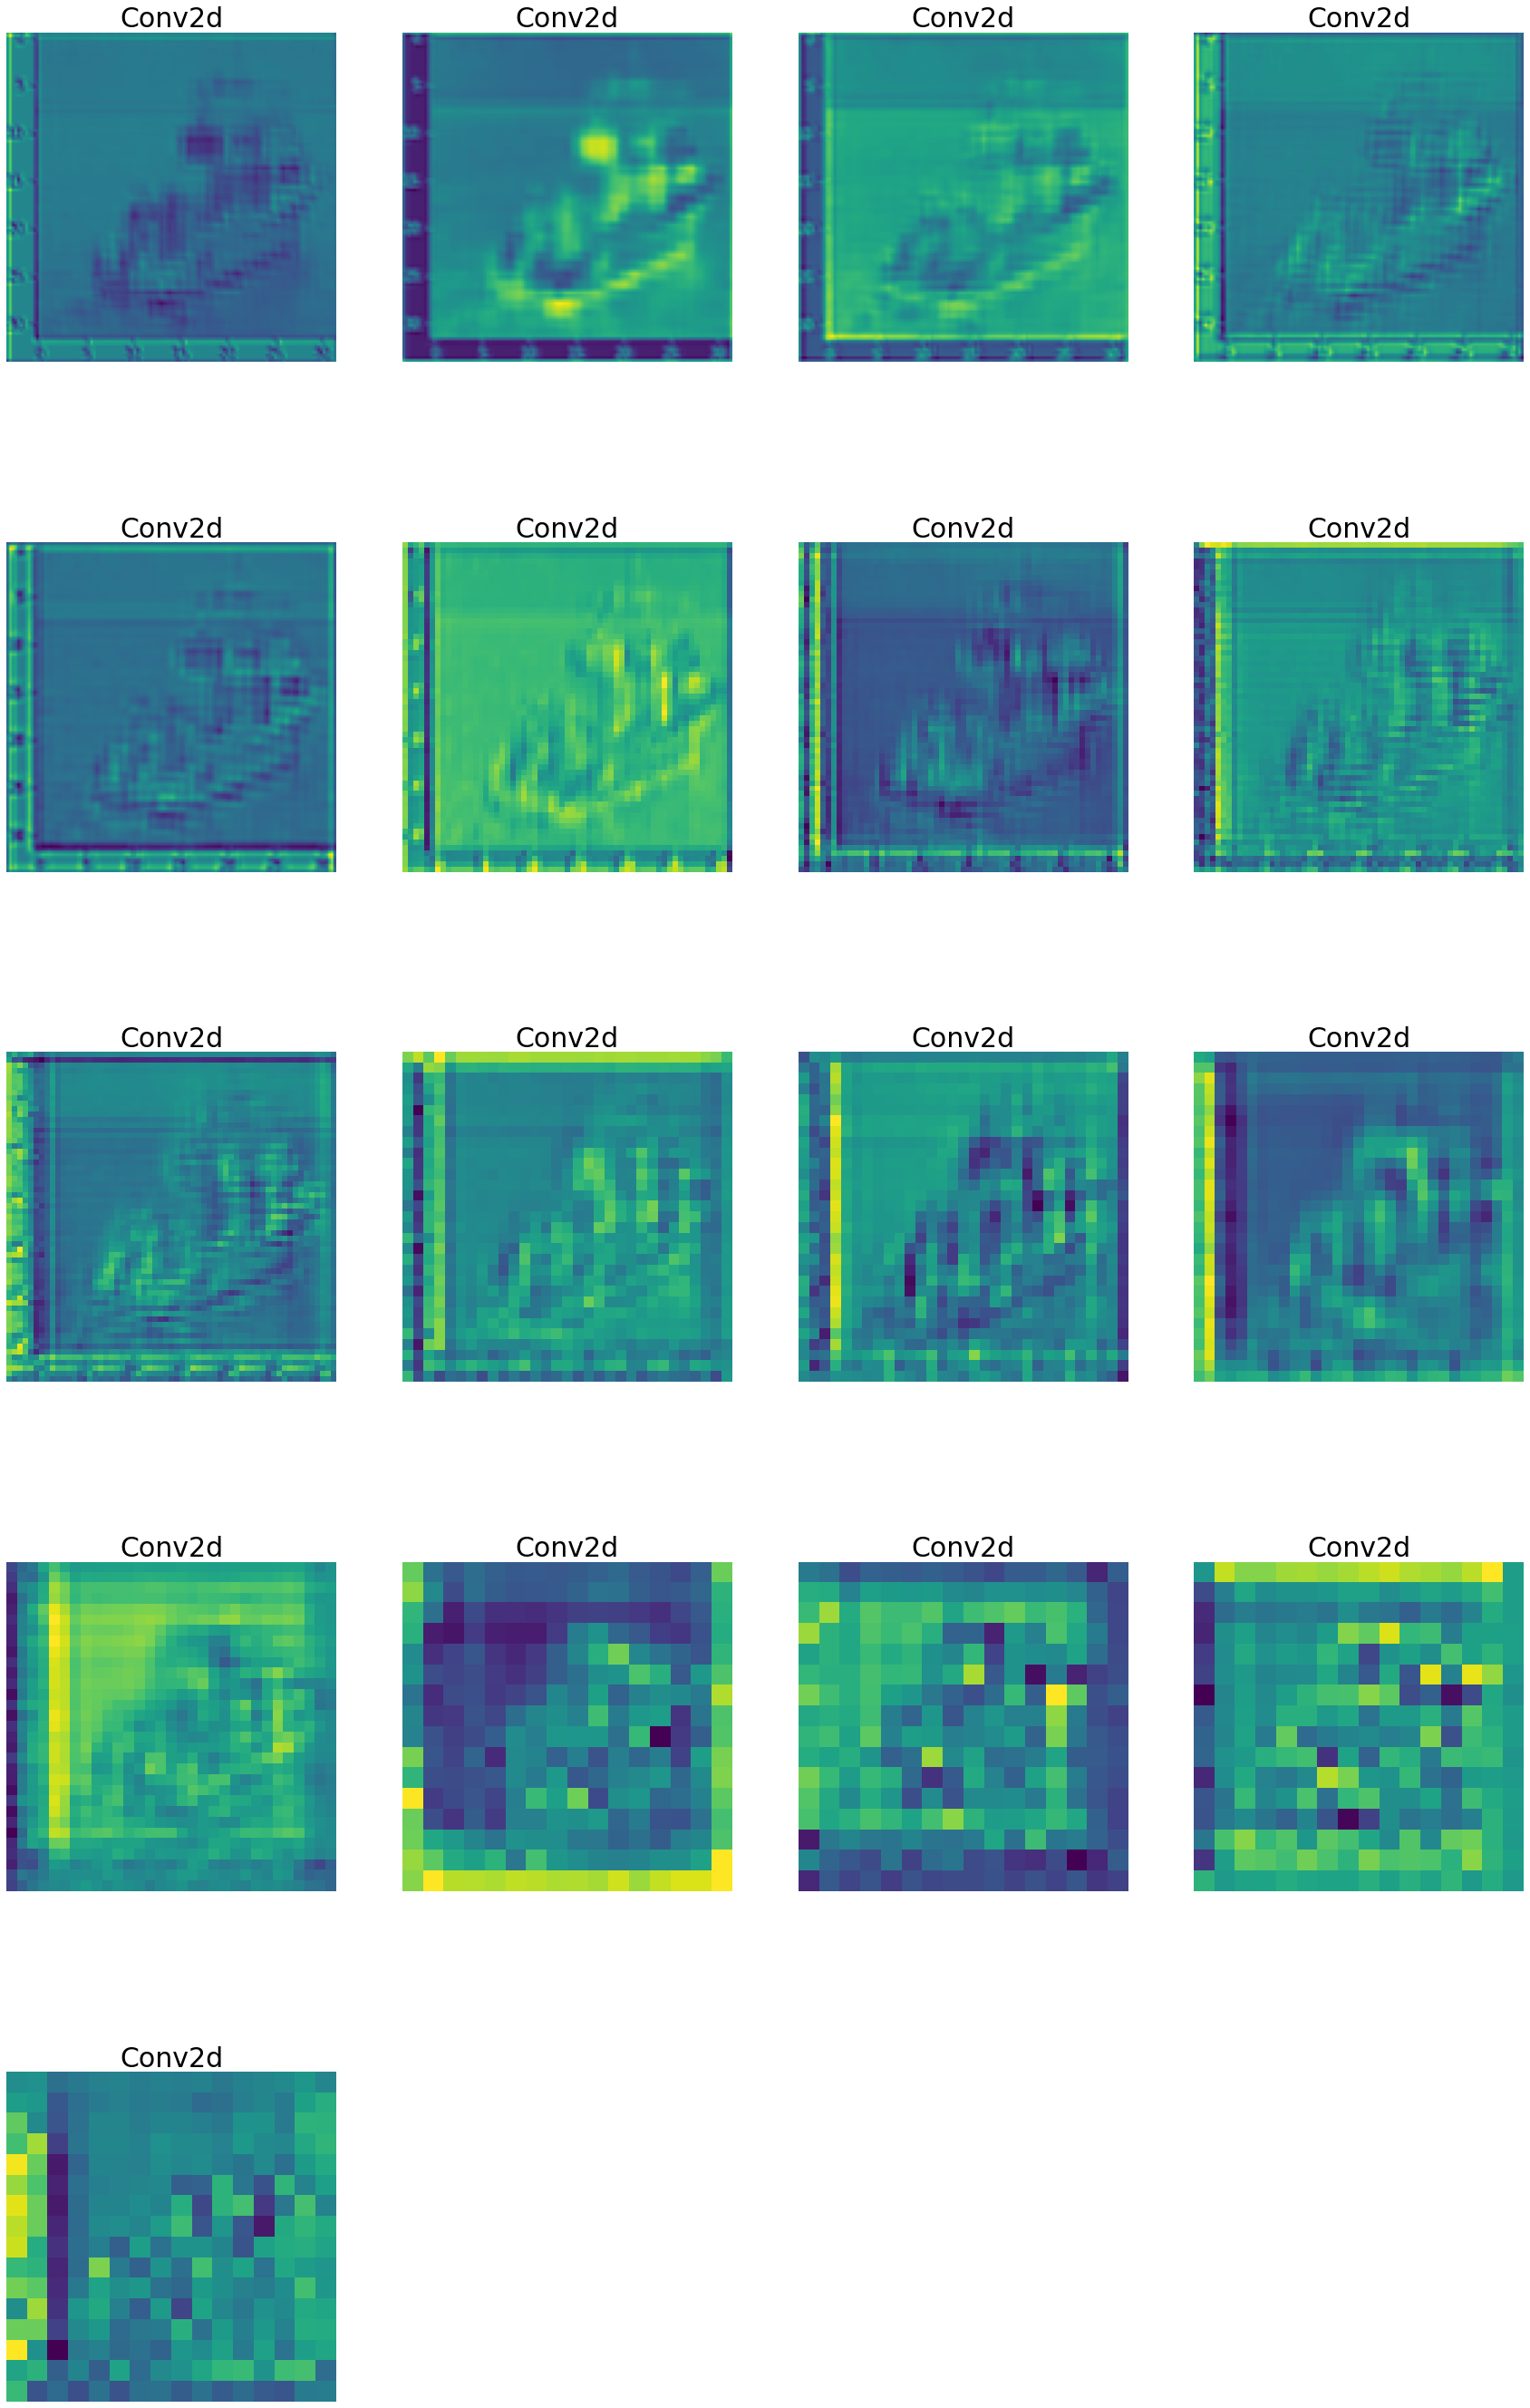

In [68]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('Part2_a_feature_maps.jpg'), bbox_inches='tight')

## FOR PART 2b

In [69]:
# we will save the conv layer weights in this list

model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []# get all the model children as list
model_children = list(resnet18_b.children())#counter to keep count of the conv layers
counter = 0#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 17
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256

(237, 235)
Image shape before: torch.Size([3, 244, 244])
Image shape after: torch.Size([1, 3, 244, 244])
17


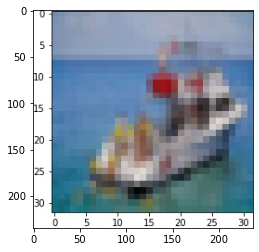

In [72]:
from PIL import Image

image = Image.open(str('ship.jpg'))
plt.imshow(image)
print(image.size)
image= other_transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))#print feature_maps
# for feature_map in outputs:
#     print(feature_map.shape)
    
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
# for fm in processed:
#     print(fm.shape)

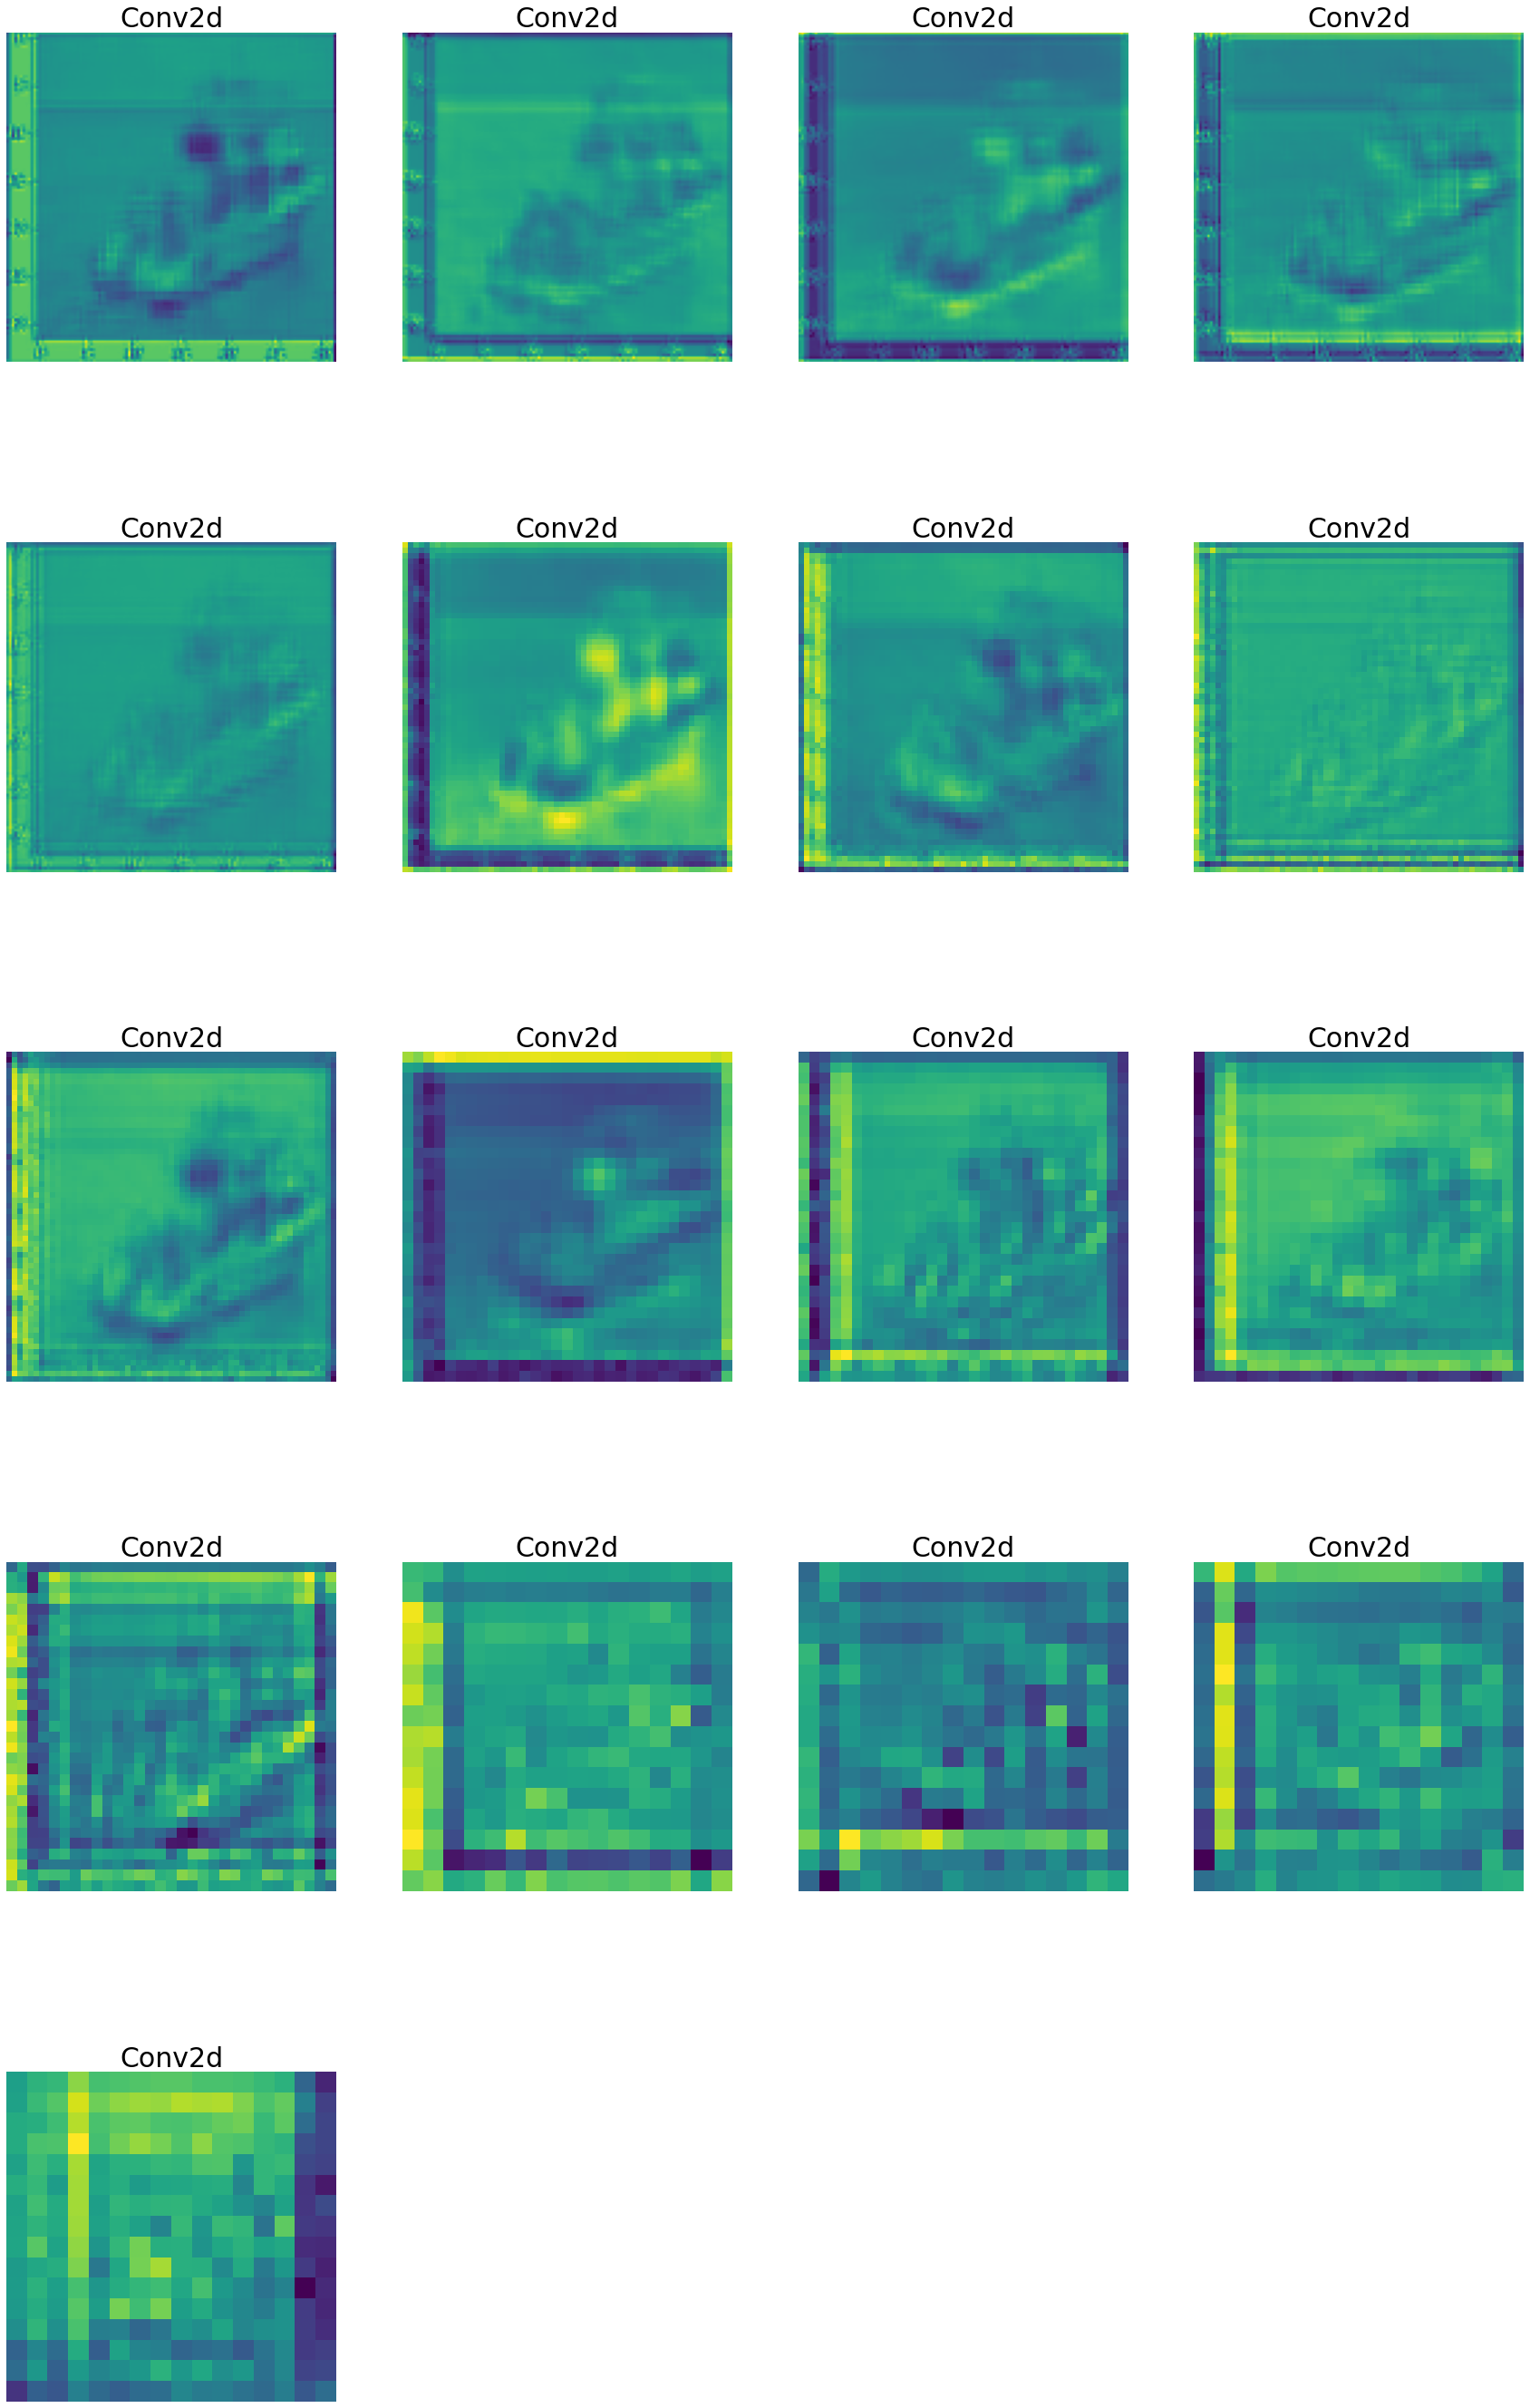

In [73]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('Part2_b_feature_maps.jpg'), bbox_inches='tight')

In [32]:
def activation_hook(inst, inp, out):
    """Run Activation hook
    Parameters
    ---------
    inst : torch.nn.Module
        The layer we want to attach the hook to
    inp : Tuple torch.Tensors
        The input to the forward method
    out : torch.Tensors
        Output of the forward method
    """
    print('Here')
    writer.add_histogram(repr(inst), out)

In [38]:
# resnet18_a.conv1.register_forward_hook(activation_hook)

In [40]:
count = 0
for image, label in tiny_trainloader:
    image, label = image.to(device), label.to(device)
    
    output = resnet18_a(image)
    count +=1
    break
print(count)

Here
1


In [4]:
# """
# Created on Sat Nov 18 23:12:08 2017

# @author: Utku Ozbulak - github.com/utkuozbulak
# """
# import os
# import numpy as np

# import torch
# from torch.optim import Adam
# from torchvision import models

# from misc_functions import preprocess_image, recreate_image, save_image


# class CNNLayerVisualization():
#     """
#         Produces an image that minimizes the loss of a convolution
#         operation for a specific layer and filter
#     """
#     def __init__(self, model, selected_layer, selected_filter):
#         self.model = model
#         self.model.eval()
#         self.selected_layer = selected_layer
#         self.selected_filter = selected_filter
#         self.conv_output = 0
#         # Create the folder to export images if not exists
#         if not os.path.exists('../generated'):
#             os.makedirs('../generated')

#     def hook_layer(self):
#         def hook_function(module, grad_in, grad_out):
#             # Gets the conv output of the selected filter (from selected layer)
#             self.conv_output = grad_out[0, self.selected_filter]
#         # Hook the selected layer
#         self.model[self.selected_layer].register_forward_hook(hook_function)

#     def visualise_layer_with_hooks(self):
#         # Hook the selected layer
#         self.hook_layer()
#         # Generate a random image
#         random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
#         # Process image and return variable
#         processed_image = preprocess_image(random_image, False)
#         # Define optimizer for the image
#         optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
#         for i in range(1, 31):
#             optimizer.zero_grad()
#             # Assign create image to a variable to move forward in the model
#             x = processed_image
#             for index, layer in enumerate(self.model):
#                 # Forward pass layer by layer
#                 # x is not used after this point because it is only needed to trigger
#                 # the forward hook function
#                 x = layer(x)
#                 # Only need to forward until the selected layer is reached
#                 if index == self.selected_layer:
#                     # (forward hook function triggered)
#                     break
#             # Loss function is the mean of the output of the selected layer/filter
#             # We try to minimize the mean of the output of that specific filter
#             loss = -torch.mean(self.conv_output)
#             print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
#             # Backward
#             loss.backward()
#             # Update image
#             optimizer.step()
#             # Recreate image
#             self.created_image = recreate_image(processed_image)
#             # Save image
#             if i % 5 == 0:
#                 im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
#                     '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
#                 save_image(self.created_image, im_path)

#     def visualise_layer_without_hooks(self):
#         # Process image and return variable
#         # Generate a random image
#         random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
#         # Process image and return variable
#         processed_image = preprocess_image(random_image, False)
#         # Define optimizer for the image
#         optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
#         for i in range(1, 31):
#             optimizer.zero_grad()
#             # Assign create image to a variable to move forward in the model
#             x = processed_image
#             for index, layer in enumerate(self.model):
#                 # Forward pass layer by layer
#                 x = layer(x)
#                 if index == self.selected_layer:
#                     # Only need to forward until the selected layer is reached
#                     # Now, x is the output of the selected layer
#                     break
#             # Here, we get the specific filter from the output of the convolution operation
#             # x is a tensor of shape 1x512x28x28.(For layer 17)
#             # So there are 512 unique filter outputs
#             # Following line selects a filter from 512 filters so self.conv_output will become
#             # a tensor of shape 28x28
#             self.conv_output = x[0, self.selected_filter]
#             # Loss function is the mean of the output of the selected layer/filter
#             # We try to minimize the mean of the output of that specific filter
#             loss = -torch.mean(self.conv_output)
#             print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
#             # Backward
#             loss.backward()
#             # Update image
#             optimizer.step()
#             # Recreate image
#             self.created_image = recreate_image(processed_image)
#             # Save image
#             if i % 5 == 0:
#                 im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
#                     '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
#                 save_image(self.created_image, im_path)

